In [1]:
!pip install dialogflow gensim==4.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install python-telegram-bot==13.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gensim
gensim.__version__

'4.3.1'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q transformers pymorphy2 stop_words annoy

In [6]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd

import catboost 

import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModelForCausalLM

In [8]:
import telegram
telegram.__version__

'13.3'

In [9]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/GB_NLP/Chat_Bot/Models/'

In [10]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [11]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [12]:
def preprocess_txt_wo_sw(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [13]:
vectorizer = CountVectorizer(ngram_range=(1, 2))

### Подключаем модель болталки

In [14]:
with open(MODEL_PATH + 'index_map.pkl', 'rb') as f:
  index_map = pickle.load(f)

In [15]:
ft_index = annoy.AnnoyIndex(300, 'angular')
ft_index.load(MODEL_PATH + 'speaker.ann') 

True

In [16]:
modelFT = FastText.load(MODEL_PATH + "ft_model")

### Подключаем модели medic_qa

In [17]:
medic_tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH + 'tokenizer_qa_medical_gen')
medic_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH + 'model_qa_medical_gen')

In [18]:
def respond_to_dialog(texts):
    prefix = '\nx:'
    for i, t in enumerate(texts):
        prefix += t
        prefix += '\nx:' if i % 2 == 1 else '\ny:'
    tokens = medic_tokenizer(prefix, return_tensors='pt')
    tokens = {k: v.to(medic_model.device) for k, v in tokens.items()}
    end_token_id = medic_tokenizer.encode('\n')[0]
    size = tokens['input_ids'].shape[1]
    output = medic_model.generate(
        **tokens, 
        eos_token_id=end_token_id,
        do_sample=True, 
        max_length=size+128, 
        repetition_penalty=3.2, 
        temperature=1,
        num_beams=3,
        length_penalty=0.01,
        pad_token_id=end_token_id
    )
    decoded = medic_tokenizer.decode(output[0])
    result = decoded[len(prefix):]
    return result.strip()

In [19]:
respond_to_dialog("Глаза в разные стороны")

'и; Здравствуйте. Обратитесь к неврологу, выполните МРТ головного мозга и шейного отдела позвоночника.; Скорее всего имеется остеохондроз пояснично-крестцового отдела позвоночника,нужно показаться неврологу.; Вам нужно исключить ШОХ,покажитесь неврологу в очном порядке.; консультация невролога; осмотр невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога; консультация невролога'

#### Подключаем модель классификации интентов

In [20]:
with open(MODEL_PATH+'cat_clsf.pkl', 'rb') as f:
  cat_clsf = pickle.load(f)

In [21]:
with open(MODEL_PATH+'vectorizer.pk', 'rb') as f:
  vectorizer = pickle.load(f)

In [22]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(300)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1 # idfs.get(word, midf)
            n_ft += 1 # idfs.get(word, midf)
    return vector_ft / n_ft

### Подключаем Телеграм бота

In [23]:
BOT_API = '6288206068:AAF88MKbMmSkflUfNsQPHWICEHUUnWwXIUw'
updater = Updater(BOT_API, use_context=True)  # Токен API к Telegram
dispatcher = updater.dispatcher

In [24]:
key_time = ['время','час']
key_ciao = ['спасибо']
def check_in_list(text, key_list):
    for w in text:
      if w in key_list:
        flag = True
        break
      else:
        flag = False
    return flag

In [25]:
print(preprocess_txt_wo_sw('сколько времени'))

['сколько', 'время']


#### Протестируем финальную функцию

In [26]:
def process(text):
    input_txt = preprocess_txt(text)
    input_txt1 = preprocess_txt_wo_sw(text)
    print(input_txt1) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_clsf.predict(vect)
    print(prediction)
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        print(now.strftime("%d-%m-%Y %H:%M") + " UTM0")
        return
    
    if check_in_list(input_txt1, key_ciao): 
            
        print('Рад был помочь!')
        return
    pred = cat_clsf.predict_proba(vect)
    print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          print("Моя твоя не понимать")
          return
        print(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    print(respond_to_dialog(text))

In [27]:
process('Расстояние до солнца')

['расстояние', 'до', 'солнце']
[0]
[[0.76053013 0.23946987]]
<p> Расстояние от Солнца29.65 -49.28 а. е. <br>Экваториальный диаметр2284 км<br>Период вращения (обратное) 6.4 дня.<br>Период обращения248.54 лет<br>Скорость движения по орбите4.74 км/сек<br>Температура видимой поверхности -2330 C <br>Масса (Земля=1)0.0022<br>Средняя плотность вещества (вода=1)2<br>Сила тяжести на поверхн. (Земля=1) <br>Кол-во спутников1</p>. 



In [28]:
process('который час?')

['который', 'час']
[0]
06-06-2023 19:54 UTM0


In [29]:
process('Головная боль и зоркость')

['головной', 'боль', 'и', 'зоркость']
[1]
[[0.28984125 0.71015875]]
е; А что это значит?; Это значит,что у вас есть хронический фарингит.; Пользователь поблагодарил за ответ на сумму 10 бонус(ов) Текст благодарности: Спасибо за консультацию!; Фарингит - это воспаление слизистой глотки и придаточных пазух носа. Чаще всего он возникает при воспалительном процессе в носоглотке (гайморит). Слизистая оболочка слухового прохода окрашивается в алый цвет из-за повышенной чувствительности к антибиотикам или фагам. При длительном течении заболевания может развиться атрофический фарингит. В зависимости от


### Теперь сам бот

In [36]:
updater = Updater(token='**************************************') # Токен API к Telegram
dispatcher = updater.dispatcher

In [37]:
def startCommand(update, context):
    update.message.reply_text('Привет! Я могу сказать, который час, дать медицинский совет или просто поболтать')

def textMessage(update, context):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt_wo_sw(update.message.text) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_clsf.predict(vect)
    #print(prediction)
    
    if check_in_list(input_txt1, key_ciao): 
            
        update.message.reply_text('Рад был помочь!')
        return
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        return

    #pred = lr_new.predict_proba(vect)
    #print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          update.message.reply_text("Не понял, уточните вопрос")
          return
        update.message.reply_text(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    update.message.reply_text(respond_to_dialog(update.message.text))

In [38]:
# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

# Start the Bot
updater.start_polling()
updater.idle()

<ipython-input-22-c9cbdedc7bdf>:8: RuntimeWarning: invalid value encountered in true_divide
  return vector_ft / n_ft


1.4142135381698608
0.4707890748977661


### Вывод

Модили обучались на небольших объемах данных, такак это затратно по времени и ресурсам. Например, полный датасет по медицине должен был обучаться около 5 часов на 3х эпохах. 

Если детальнее проработать входные данные и провести полное обучение, то может получиться хорошая модель. 

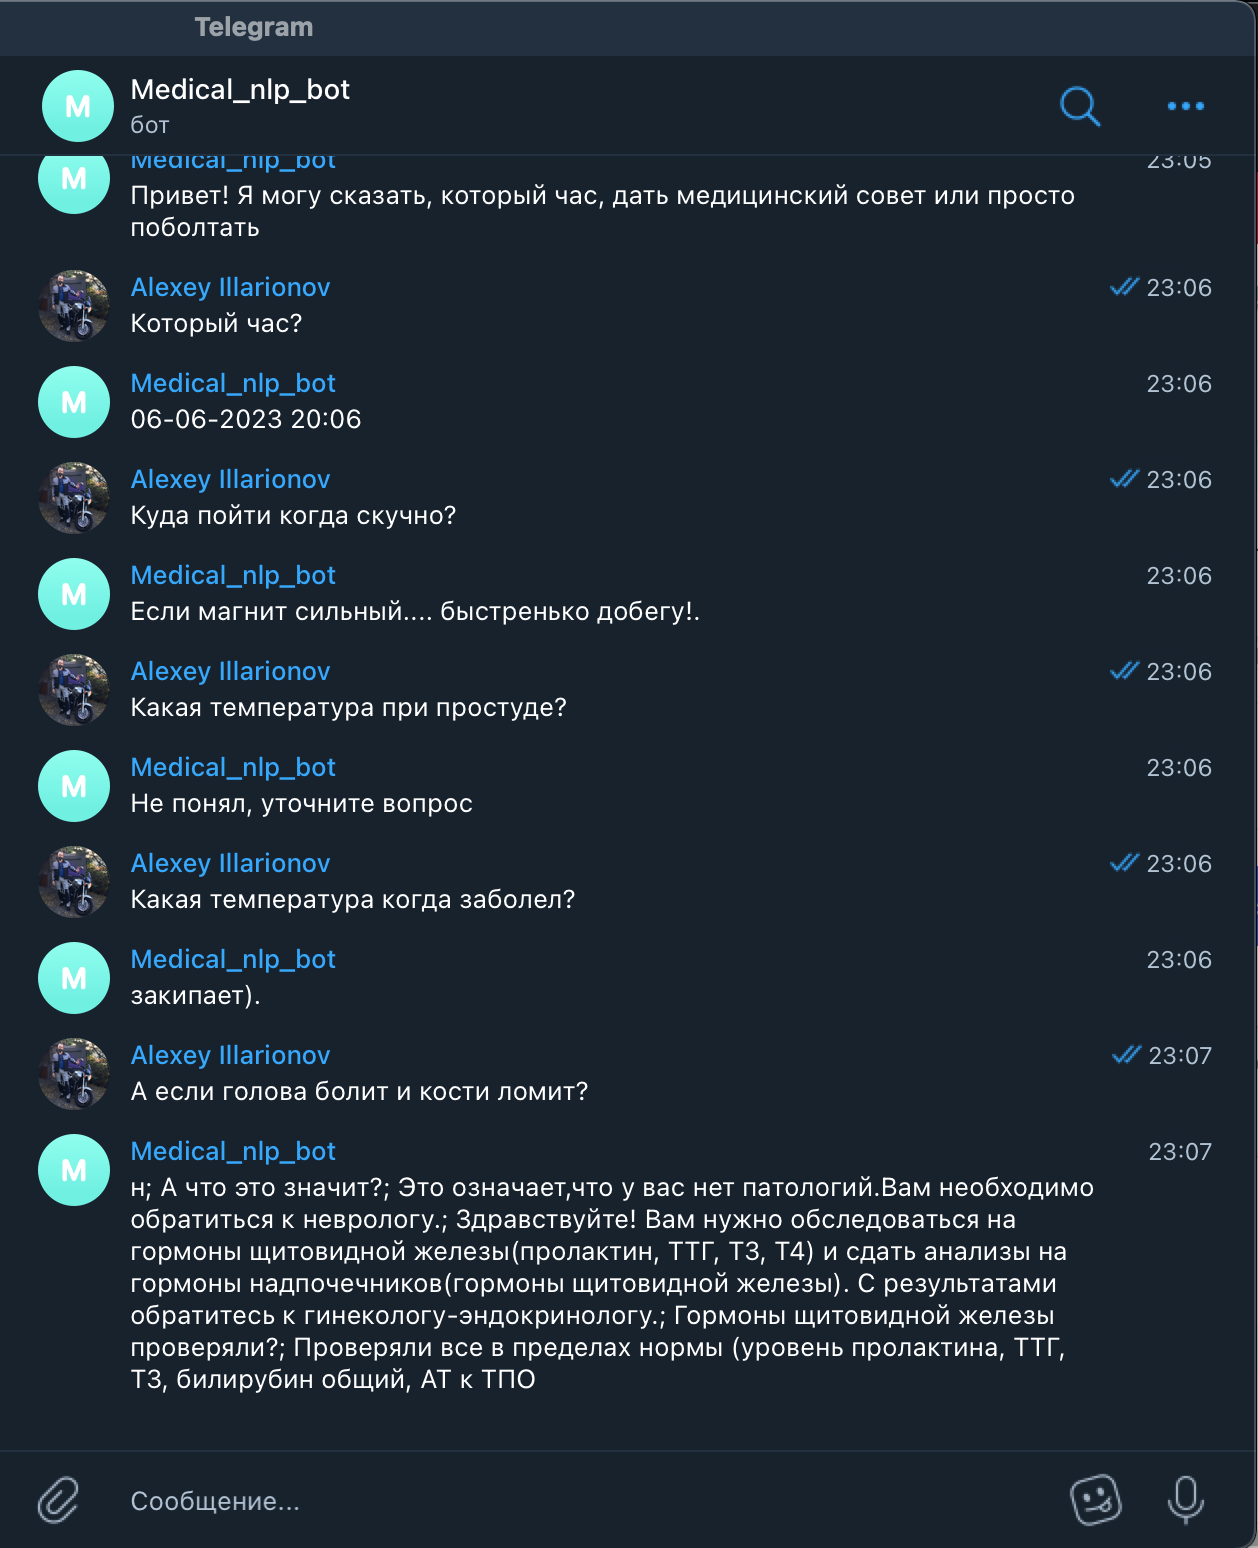